In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as graph
import seaborn as sns

# Intro to linear regression

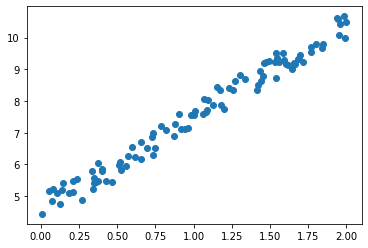

In [5]:
x = 2 * np.random.rand(100, 1)
y = 4 + 3 * x + np.random.rand(100, 1)

graph.scatter(x, y)
graph.show()

###### Compute Normal Equation <br>
θ = (XTX)−1 XT y

In [6]:
x_b = np.c_[np.ones((100, 1)), x] # add x0 = 1 to each instance
theta_best = np.linalg.inv(x_b.T.dot(x_b)).dot(x_b.T).dot(y)

In [7]:
theta_best

array([[4.60513936],
       [2.90793613]])

In [8]:
x_new = np.array([[0], [2]])
x_new_b = np.c_[np.ones((2, 1)), x_new]
y_pred = x_new_b.dot(theta_best)
y_pred

array([[ 4.60513936],
       [10.42101161]])

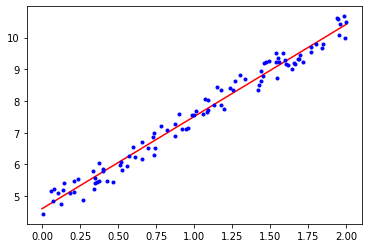

In [9]:
graph.plot(x_new, y_pred, 'r-')
graph.plot(x, y, 'b.')
graph.show()

In [10]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x, y)
print(lin_reg.intercept_, lin_reg.coef_)

[4.60513936] [[2.90793613]]


# Gradient Descent 
- for when we have too many training instances to fit in memory
- minimize cost function
- learning rate hyperparameter: steps size
- cost function is convex, so almost guaranteed to reach global minimum

Batch Gradient descent: Calculates over the full training set x

In [12]:
learning_rate = 0.1
n_iterations = 1000
m = 100

theta = np.random.rand(2, 1)

for iteration in range(n_iterations):
    gradients = 2/m * x_b.T.dot(x_b.dot(theta) - y)
    theta = theta - learning_rate * gradients
    
print(theta)

[[4.60513936]
 [2.90793613]]


# Stochastic Gradient Descent 
Picks random instance in training set at every step, and computes gradients based solely on that instance <br>
But can jump out of global minimum. Can make such that learning rate gets smaller as get close to minimum
- Done by adjusting learning schedule: function that determine learning rate at each iteration

In [14]:
n_epochs = 50
t0, t1 = 5, 50 # Learning schedule paramters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.rand(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = x_b[random_index: random_index + 1]
        yi = y[random_index: random_index + 1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        
print(theta)

[[4.59470962]
 [2.90378226]]


In [18]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty = None, eta0=0.1)
sgd_reg.fit(x, y.ravel())

print(sgd_reg.intercept_, sgd_reg.coef_)

[4.57544855] [2.92483148]


# Mini Batch Gradient Descent
Like stochastic gradient descent, but used mini batches of instances instead of just one instance

# Polynomial Regression

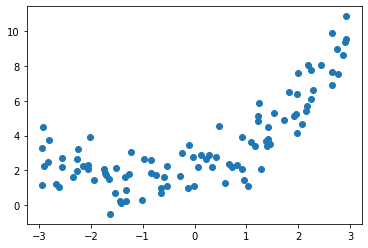

In [21]:
m = 100
x = 6 * np.random.rand(m, 1) - 3
y = 0.5 * x**2 + x + 2 + np.random.randn(m, 1)

graph.scatter(x, y)
graph.show()

In [22]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree = 2, include_bias=False)
x_poly = poly_features.fit_transform(x)

lin_reg = LinearRegression().fit(x_poly, y)
print(lin_reg.intercept_, lin_reg.coef_)

[1.8901854] [[1.05054902 0.48969934]]


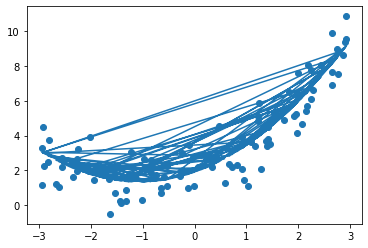

In [26]:
y_pred = lin_reg.predict(x_poly)

graph.scatter(x, y)
graph.plot(x, y_pred)
graph.show()

# Learning Curves

Plots of model's performance on the training set and the validation set as a function of the training set size

In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curve(model, x, y):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(x_train)):
        model.fit(x_train[:m], y_train[:m])
        y_train_pred = model.predict(x_train[:m])
        y_val_pred = model.predict(x_val)
        
        train_errors.append(mean_squared_error(y_train[:m], y_train_pred))
        val_errors.append(mean_squared_error(y_val, y_val_pred))
        
    graph.plot(np.sqrt(train_errors), 'r-+', linewidth = 2, label='train')
    graph.plot(np.sqrt(val_errors), 'b-', linewidth = 3, label='val')
    graph.legend()
    graph.xlabel('Training set size')
    graph.ylabel('RMSE')

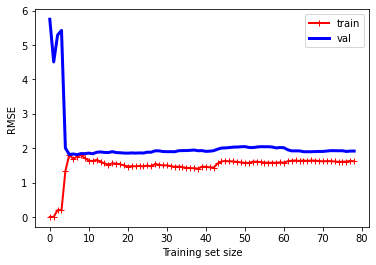

In [34]:
lin_reg = LinearRegression()
plot_learning_curve(lin_reg, x, y)

(0.0, 5.0)

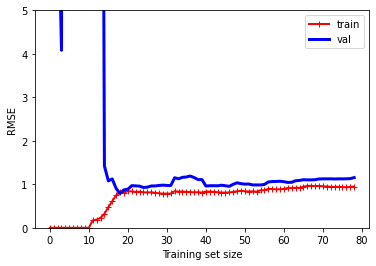

In [38]:
from sklearn.pipeline import Pipeline

poly_reg = Pipeline([("poly_features", PolynomialFeatures(degree=10, include_bias=False)), 
                     ("lin_reg", LinearRegression())])

plot_learning_curve(poly_reg, x, y)
graph.ylim(0, 5)

# Ridge Regression

In [42]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(x, y)
print(ridge_reg.predict([[1.5]]))

sgd_reg = SGDRegressor(penalty='l2') # L2 is ridge regression
sgd_reg.fit(x, y.ravel())
print(sgd_reg.predict([[1.5]]))

[[5.00687284]]
[4.98079951]


# Early Stopping

In [47]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

# prepare the data
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])

x_train, x_val, y_train, y_val = train_test_split(x, y)

x_train_poly_scaled = poly_scaler.fit_transform(x_train)
x_val_poly_scaled = poly_scaler.fit_transform(x_val)

sgd_reg = SGDRegressor(max_iter=1, tol = -np.infty, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005)

minimium_val_error = float('inf')
best_epoch, best_model = None, None

for epoch in range(1000):
    sgd_reg.fit(x_train_poly_scaled, y_train) # continues where left off
    y_val_pred = sgd_reg.predict(x_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_pred)
    
    if val_error < minimium_val_error:
        minimium_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

# Logistic Regression

In [50]:
from sklearn import datasets
iris = datasets.load_iris()

x = iris['data'][:, 3:]
y = (iris['target'] == 2).astype(np.int)

In [52]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression().fit(x, y)

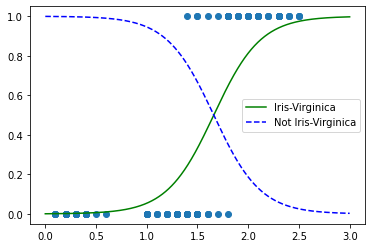

In [55]:
x_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(x_new)

graph.plot(x_new, y_proba[:, 1], 'g-', label='Iris-Virginica')
graph.plot(x_new, y_proba[:, 0], 'b--', label='Not Iris-Virginica')
graph.scatter(x, y)
graph.legend()
graph.show()

# Softmax Regression

Support multiclasses directly; normalized exponential to the scores

In [56]:
x = iris["data"][:, (2, 3)] # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10)
softmax_reg.fit(x, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)